In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import missingno as msno  ##pip install missingno


### **Read File**

In [2]:
null_df = pd.read_csv('Data/car_v2.csv')

### **Initial count of Rows and Column**

In [3]:
null_df.shape

(5551, 126)

### **Are there duplicate rows?**

In [4]:
null_df.duplicated()

0       False
1       False
2       False
3       False
4       False
5       False
6       False
7       False
8       False
9       False
10      False
11      False
12      False
13      False
14      False
15      False
16      False
17      False
18      False
19      False
20      False
21      False
22      False
23      False
24      False
25      False
26      False
27      False
28      False
29      False
        ...  
5521    False
5522    False
5523    False
5524    False
5525    False
5526    False
5527    False
5528    False
5529    False
5530    False
5531    False
5532    False
5533    False
5534    False
5535    False
5536    False
5537    False
5538    False
5539    False
5540    False
5541    False
5542    False
5543    False
5544    False
5545    False
5546    False
5547    False
5548    False
5549    False
5550    False
Length: 5551, dtype: bool


### **Count of null at the Columns level **

### There are 127 rows and some rows with null values. Many of these null rows have a count of only nine nulls 

In [5]:
null_df.isnull().sum().count()

126

In [6]:
#null_df.isnull().sum()
null_df.isnull().sum().sort_values(ascending=False)

% Unprofitable Banks                5551
% Banks with Earnings Gains         5551
Trading Acct Gains Fees             3698
Earnings Cov Net Chargeoffs         2343
namehcr                             1251
Credit Loss Prov to Chargeoffs       691
Loan Loss Allow to noncurr Loans     578
Loss Allow to Loans                   46
Net Chargeoffs to Loans               45
Noncurrent Loans to Loans             37
Average Total Loans                   36
Net Loans Lease to core deposits      24
Assets per Emp                        21
Cash Div to Net Inc                   11
Average earning assets                10
Yield on Earning Assets               10
Cost of Funding Earnings Assets       10
Net Interest Margin                   10
Volatile Liabilities                   9
Derivatives                            9
Sale Conversion Ret Stock              9
Tier 2 Risk-based capital              9
Tier One Capital                       9
Loans Leases held for sale             9
FHLB advances   


### **More Analysis**



### Find a pattern: Are there several columns with null values at the same index rows?  

###  Retreive the row number for the solitary row which has "lnatres" as null

In [7]:
null_columns=null_df.columns[null_df.isnull().any()] 
# Step one - Assign null_columns

In [8]:
print(null_df[null_df["Number Employees"].isnull()][null_columns])  

# Step two - 
#Are there other columns with null value at the same index than sample column "Number Employees"
#The answer is Yes. It appears to ber several colums with nine null value at the same index as seen in the results below.

     namehcr  Number Employees  Cash Balance IB  Loan Allowance Loss  \
268      NaN               NaN              NaN                  NaN   
282      NaN               NaN              NaN                  NaN   
313      NaN               NaN              NaN                  NaN   
390      NaN               NaN              NaN                  NaN   
3127     NaN               NaN              NaN                  NaN   
3194     NaN               NaN              NaN                  NaN   
4175     NaN               NaN              NaN                  NaN   
4176     NaN               NaN              NaN                  NaN   
4380     NaN               NaN              NaN                  NaN   

      Bank Premises Fixed Assets  Other RE Owned  Goodwill Intangibles  \
268                          NaN             NaN                   NaN   
282                          NaN             NaN                   NaN   
313                          NaN             NaN         

### Removing null values at indexes = 268, 282, 313, 390, 3127, 3194, 4175, 4176, 4380?  

In [9]:
#Testing null value at index row= 282
null_df.loc[282]['Number Employees']

nan

In [10]:
null_df.shape

(5551, 126)

In [11]:
filtered_null_step1= null_df[null_df['Number Employees'].notnull()]

In [12]:
#filtered_null_step1.loc[282]['Number Employees']

In [13]:
filtered_null_step1.shape
# AS seenm, we removed a total of nine rows. Our dataset shape is now 5542 rowns (previously 5551 rows)

(5542, 126)

In [14]:
filtered_null_step1.isnull().sum().sort_values(ascending=False)

% Unprofitable Banks                  5542
% Banks with Earnings Gains           5542
Trading Acct Gains Fees               3689
Earnings Cov Net Chargeoffs           2334
namehcr                               1242
Credit Loss Prov to Chargeoffs         682
Loan Loss Allow to noncurr Loans       569
Noncurrent Loans to Loans               37
Loss Allow to Loans                     37
Net Chargeoffs to Loans                 36
Average Total Loans                     36
Net Loans Lease to core deposits        15
Assets per Emp                          12
Cash Div to Net Inc                      2
% Insured                                1
Average earning assets                   1
Net Loans Lease to Deposits              1
Net Interest Margin                      1
Cost of Funding Earnings Assets          1
Yield on Earning Assets                  1
Earning Assets                           0
Life Insurance Assets                    0
Subordinated Debt                        0
Adjusted Av

### Dropping Columns containing >80% of nulls

In [15]:
null_df = filtered_null_step1.columns[filtered_null_step1.isna().any()].tolist()

In [16]:
#List of columns containing nulls
null_df

['namehcr',
 '% Insured',
 '% Unprofitable Banks',
 '% Banks with Earnings Gains',
 'Yield on Earning Assets',
 'Cost of Funding Earnings Assets',
 'Net Interest Margin',
 'Net Chargeoffs to Loans',
 'Credit Loss Prov to Chargeoffs',
 'Earnings Cov Net Chargeoffs',
 'Assets per Emp',
 'Cash Div to Net Inc',
 'Loss Allow to Loans',
 'Loan Loss Allow to noncurr Loans',
 'Noncurrent Loans to Loans',
 'Net Loans Lease to Deposits',
 'Net Loans Lease to core deposits',
 'Average earning assets',
 'Average Total Loans',
 'Trading Acct Gains Fees']

### Dropping Columns containing >80% of nulls

In [17]:
#filtered_null_step2 = filtered_null_step1.dropna(thresh=500, axis=1)  #Keep only the rows with at least 500 non-na values

In [18]:
filtered_null_step2 = filtered_null_step1.dropna(thresh=0.8*len(filtered_null_step1), axis=1)

In [19]:
#filtered_null_step2 = filtered_null_step1.loc[:, filtered_null_step1.isnull().sum() < 0.8*filtered_null_step1.shape[0]]

In [20]:
filtered_null_step2.shape

(5542, 121)

In [30]:
filtered_null_step2.isnull().sum().sort_values(ascending=False)

Credit Loss Prov to Chargeoffs        682
Loan Loss Allow to noncurr Loans      569
Noncurrent Loans to Loans              37
Loss Allow to Loans                    37
Net Chargeoffs to Loans                36
Average Total Loans                    36
Net Loans Lease to core deposits       15
Assets per Emp                         12
Cash Div to Net Inc                     2
Yield on Earning Assets                 1
Cost of Funding Earnings Assets         1
Net Interest Margin                     1
Average earning assets                  1
% Insured                               1
Net Loans Lease to Deposits             1
Bank Equity                             0
All Other Liabilities                   0
Total Equity                            0
Subordinated Debt                       0
Net Operating Income                    0
Perpertual Pref Stock                   0
Other Borrowed Funds                    0
Surplus                                 0
Undivided Profits                 

In [22]:
null_df_1 = filtered_null_step2.columns[filtered_null_step2.isna().any()].tolist()

In [23]:
null_df_1

['% Insured',
 'Yield on Earning Assets',
 'Cost of Funding Earnings Assets',
 'Net Interest Margin',
 'Net Chargeoffs to Loans',
 'Credit Loss Prov to Chargeoffs',
 'Assets per Emp',
 'Cash Div to Net Inc',
 'Loss Allow to Loans',
 'Loan Loss Allow to noncurr Loans',
 'Noncurrent Loans to Loans',
 'Net Loans Lease to Deposits',
 'Net Loans Lease to core deposits',
 'Average earning assets',
 'Average Total Loans']

In [24]:
#msno.matrix(filtered_null_step2)

### Fill out Columns containing nulls > 500 with its mean value

In [25]:
filtered_null_step2["Credit Loss Prov to Chargeoffs"].describe()

count      4860.000000
mean         49.740703
std        4265.386256
min     -117500.000000
25%           0.000000
50%          60.000000
75%         222.222222
max       80000.000000
Name: Credit Loss Prov to Chargeoffs, dtype: float64

In [29]:
filtered_null_step2["Loan Loss Allow to noncurr Loans"].describe()

count      4973.000000
mean       1062.504461
std        6091.322654
min           0.000000
25%          86.327260
50%         175.291375
75%         431.611111
max      140700.000000
Name: Loan Loss Allow to noncurr Loans, dtype: float64

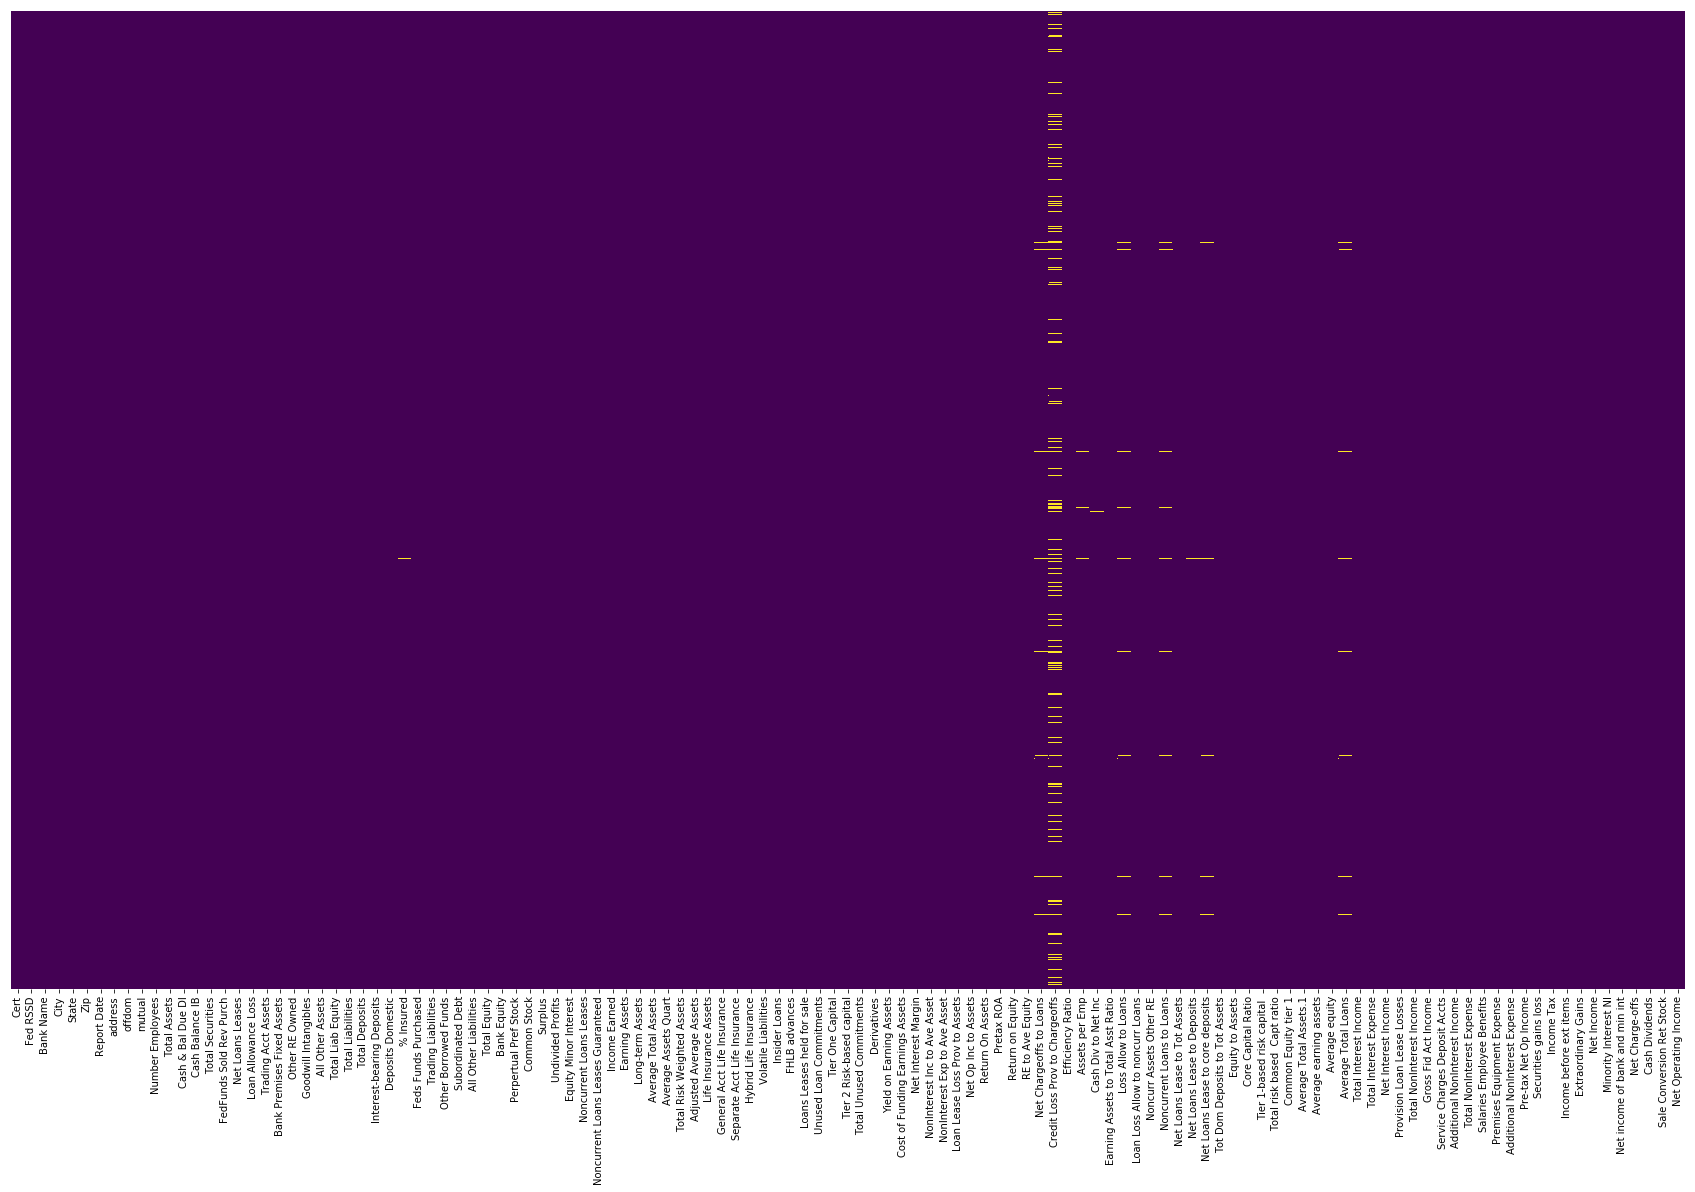

In [36]:
fig = plt.figure(figsize=(30,18))
sns.heatmap(filtered_null_step2.isnull(),yticklabels=False,cbar=False,cmap='viridis')


In [35]:
filtered_null_step2.shape
# As seen, we removed a total of five columns.

(5542, 121)

In [ ]:
filtered_null_step2.isnull().sum().sort_values(ascending=False)
#filtered_null_step2 = filtered_null_step2.iloc[filtered_null_step2.isnull().sum(1).sort_values(ascending=0).index]

In [51]:
filtered_null_step2['Loan Loss Allow to noncurr Loans'].fillna(value=filtered_null_step2['Loan Loss Allow to noncurr Loans'].mean())

0          34.189316
1        2922.222222
2        1062.504461
3        1484.415584
4          56.932153
5          60.877514
6         113.526808
7         116.981132
8        3243.939394
9         234.765101
10         85.102421
11         95.343880
12         22.815853
13         14.432234
14        270.689655
15        194.622996
16         70.973783
17       1845.454545
18        280.971605
19         89.197861
20         67.391304
21        222.331567
22         49.754501
23        146.372240
24         71.578187
25       1143.670886
26         57.894737
27       3238.333333
28       1006.451613
29         94.301471
            ...     
5521      167.446211
5522     1155.982275
5523      360.321716
5524       83.718604
5525      101.461039
5526      107.672634
5527      134.995383
5528       42.310068
5529      278.335535
5530       31.184408
5531      182.659523
5532      128.894298
5533      276.565465
5534       87.124464
5535     1669.090909
5536       68.675519
5537     1062

In [52]:
filtered_null_step2['Credit Loss Prov to Chargeoffs'].fillna(value=filtered_null_step2['Credit Loss Prov to Chargeoffs'].mean())

0         77.083333
1       -300.000000
2          0.000000
3        375.000000
4        142.857143
5         49.740703
6        389.830509
7          0.000000
8        -80.000000
9        294.500000
10        49.740703
11     -1285.714286
12         0.000000
13        49.740703
14        29.069767
15        70.218623
16      2200.000000
17     -5333.333333
18      1796.033403
19        21.968366
20        49.740703
21       317.073171
22       312.500000
23        49.740703
24       148.305085
25        49.740703
26       263.157895
27         0.000000
28        49.740703
29         0.000000
           ...     
5521     461.538462
5522      35.442436
5523       0.000000
5524     362.277981
5525    -375.000000
5526    -146.341463
5527      69.565217
5528      49.740703
5529       0.000000
5530     228.571429
5531     566.037736
5532      49.740703
5533    -143.820225
5534      49.740703
5535      49.740703
5536     517.857143
5537      49.740703
5538      49.740703
5539       0.000000


In [53]:
filtered_null_step2.isnull().sum().sort_values(ascending=False)

Credit Loss Prov to Chargeoffs        682
Loss Allow to Loans                    37
Noncurrent Loans to Loans              37
Net Chargeoffs to Loans                36
Average Total Loans                    36
Net Loans Lease to core deposits       15
Assets per Emp                         12
Cash Div to Net Inc                     2
Yield on Earning Assets                 1
Cost of Funding Earnings Assets         1
Net Interest Margin                     1
Average earning assets                  1
% Insured                               1
Net Loans Lease to Deposits             1
Total Equity                            0
Perpertual Pref Stock                   0
All Other Liabilities                   0
Bank Equity                             0
Subordinated Debt                       0
Net Operating Income                    0
Common Stock                            0
Other Borrowed Funds                    0
Undivided Profits                       0
Equity Minor Interest             